<a href="https://colab.research.google.com/github/rafael-bork/Applied-Machine-Learning/blob/main/Assignment2/Aquifer_depth_to_groundwater.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cross-validation RMSE (per fold): [2.1497692  0.34698303 0.41661317 0.17740671 2.08969134]
Mean RMSE: 1.0361


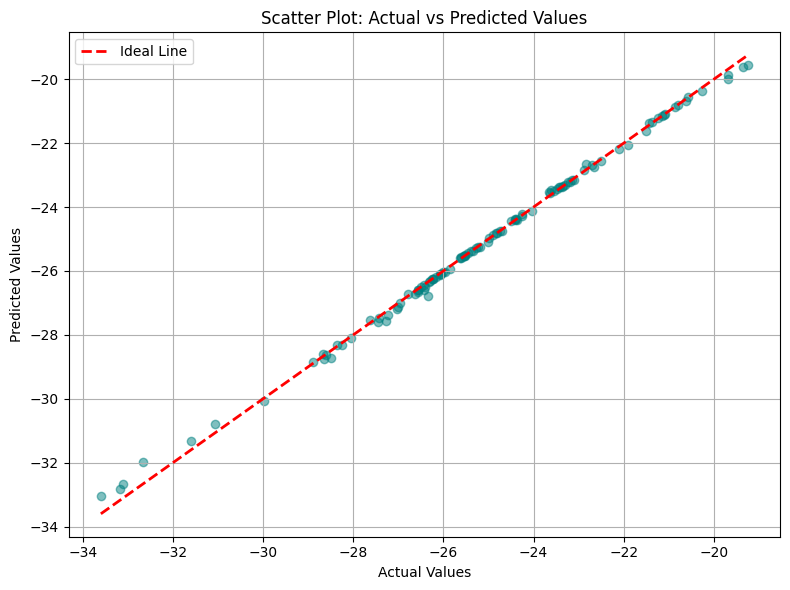

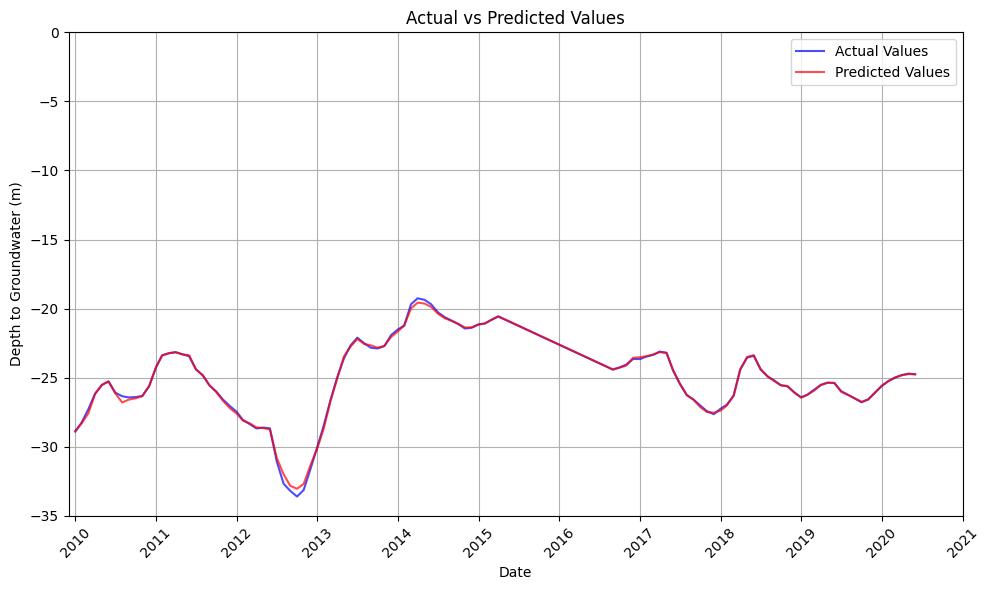

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.preprocessing import StandardScaler


def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath)
    df['date'] = pd.to_datetime(df['date'], dayfirst=True)
    df.set_index('date', inplace=True)

    # Substitui 0 por NaN
    cols_to_clean = ['river_hydrometry_m', 'drainage_m3', 'depth_to_groundwater_m']
    df[cols_to_clean] = df[cols_to_clean].replace(0, np.nan)

    # Agrega por mês (mediana)
    df_monthly = df.resample('ME').median()

    return df_monthly


def create_lag_features(df, variables, n_lags=12):
    df_lagged = df.copy()

    for var in variables:
        for lag in range(0, n_lags + 1):
            df_lagged[f'{var}_month_K-{lag}'] = df[var].shift(lag)

    X = df_lagged.drop(columns=['depth_to_groundwater_m_month_K-0'])
    y = df_lagged['depth_to_groundwater_m_month_K-0']

    X = X.dropna()
    y = y.loc[X.index]

    return X, y


def train_and_evaluate(X, y, groups):
    model = RandomForestRegressor(n_estimators=100, random_state=42)

    cv = GroupKFold(n_splits=5)

    scores = cross_val_score(
        model, X, y,
        cv=cv,
        scoring='neg_mean_squared_error',
        groups=groups
    )

    print(f"Cross-validation RMSE (per fold): {np.sqrt(-scores)}")
    print(f"Mean RMSE: {np.mean(np.sqrt(-scores)):.4f}")

    # Ajustando o modelo nos dados completos
    model.fit(X, y)

    return model


def plot_actual_vs_predicted(model, X, y):
    y_pred = model.predict(X)

    plt.figure(figsize=(10, 6))
    plt.plot(y.index, y, label='Actual Values', color='blue', alpha=0.7)
    plt.plot(y.index, y_pred, label='Predicted Values', color='red', alpha=0.7)
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Date')
    plt.xlim(pd.to_datetime('2009-12-31'), pd.to_datetime('2021-1-1'))
    plt.xticks(pd.date_range(start='2009-12-31', end=pd.to_datetime('2021-12-31'), freq='YE-JAN'), rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.ylabel('Depth to Groundwater (m)')
    plt.ylim(-35, 0)
    plt.yticks(np.arange(-35, 1, 5))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_scatter_actual_vs_predicted(model, X, y):
    y_pred = model.predict(X)

    plt.figure(figsize=(8, 6))
    plt.scatter(y, y_pred, alpha=0.5, color='teal')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Ideal Line')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Scatter Plot: Actual vs Predicted Values')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def main():
    filepath = r'https://raw.githubusercontent.com/rafael-bork/Applied-Machine-Learning/5f68d2b9e08334d07bdf39136d31d866d501fb45/Assignment2/aquifer_time_series.csv'
    df = load_and_preprocess_data(filepath)

    variables = ['rainfall_mm', 'temperature_C', 'drainage_m3', 'river_hydrometry_m', 'depth_to_groundwater_m']
    X, y = create_lag_features(df, variables, n_lags=12)

    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)

    groups = X.index.year

    model = train_and_evaluate(X_scaled, y, groups)

    plot_scatter_actual_vs_predicted(model, X_scaled, y)

    plot_actual_vs_predicted(model, X_scaled, y)

if __name__ == '__main__':
    main()